In [1]:
import os
from typing import Tuple, Optional, Sequence, Dict, Any, List

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import PatchTSTConfig, PatchTSTForClassification
import torch.optim as optim
device = 'cuda:0' 

In [2]:
class FirstSecondsTimeseriesDataset(Dataset):
    """
    A dataset that returns the first `window_seconds` of each valid 15-second block (id),
    reading:
      - cluster_results.csv for valid IDs and cluster labels
      - clustering_data.csv (long CSV) for rtt_token and rtt_nearest time series

    Each sample returns:
      x: Tensor of shape (C, T) where C depends on selected channels (nearest, token)
      y: cluster label (LongTensor scalar)
      meta: dict with id and start_ts (pd.Timestamp)
    """

    def __init__(
        self,
        clustering_csv_path: str,
        clusters_csv_path: str,
        window_seconds: float = 1.0,
        freq_ms: int = 10,
        channels: Sequence[str] = ("nearest", "token"),
        restrict_clusters: Optional[Sequence[int]] = None,
        ensure_exact_len: bool = True,
        nearest_pad_value: Optional[float] = None,  # None => pad with last seen; if not available, NaN
        dtype_token: np.dtype = np.int16,
        dtype_nearest: np.dtype = np.float32,
    ):
        """
        Parameters:
          clustering_csv_path: path to 'clustering_data.csv' (columns: id, timestamp, rtt_token, rtt_nearest)
          clusters_csv_path: path to 'cluster_results.csv' (columns include id, timestamp, cluster)
          window_seconds: how many seconds from the start of the block to return (default 1.0)
          freq_ms: sampling interval in milliseconds (default 10ms => 100 samples/second)
          channels: which channels to return; options: "nearest", "token"
          restrict_clusters: optionally restrict dataset to certain cluster labels
          ensure_exact_len: if True, pad/truncate windows to exact length T
          nearest_pad_value: when padding nearest channel:
             - None: use last seen value within the window; if none, use NaN
             - float: use this value (e.g., 0.0) for padding
          dtype_token: dtype for token channel (default int16)
          dtype_nearest: dtype for nearest channel (default float32)
        """
        assert set(channels).issubset({"nearest", "token"}), "channels must be subset of {'nearest','token'}"

        self.clustering_csv_path = clustering_csv_path
        self.clusters_csv_path = clusters_csv_path
        self.window_seconds = float(window_seconds)
        self.freq_ms = int(freq_ms)
        self.channels = tuple(channels)
        self.ensure_exact_len = ensure_exact_len
        self.nearest_pad_value = nearest_pad_value
        self.dtype_token = dtype_token
        self.dtype_nearest = dtype_nearest

        self.samples_per_sec = int(1000 // self.freq_ms)
        self.T = int(round(self.window_seconds * self.samples_per_sec))  # number of timesteps in window

        # 1) Load cluster labels (valid ids and block start timestamps)
        clusters_df = pd.read_csv(self.clusters_csv_path)
        if "timestamp" in clusters_df.columns:
            clusters_df["timestamp"] = pd.to_datetime(clusters_df["timestamp"])
        else:
            raise ValueError("clusters_csv must have a 'timestamp' column for block start times.")

        # Keep only id and cluster (and timestamp for start)
        clusters_df = clusters_df[["id", "timestamp", "cluster"]].drop_duplicates()
        clusters_df["id"] = clusters_df["id"].astype(np.int32)
        clusters_df["cluster"] = clusters_df["cluster"].astype(np.int8)

        if restrict_clusters is not None:
            clusters_df = clusters_df[clusters_df["cluster"].isin(restrict_clusters)].copy()

        # 2) Load long CSV (all timesteps)
        # Only the columns we need
        long_df = pd.read_csv(
            self.clustering_csv_path,
            usecols=["id", "timestamp", "rtt_token", "rtt_nearest"],
            parse_dates=["timestamp"],
        )
        long_df["id"] = long_df["id"].astype(np.int32)
        long_df["rtt_token"] = long_df["rtt_token"].astype(self.dtype_token)
        long_df["rtt_nearest"] = long_df["rtt_nearest"].astype(self.dtype_nearest)

        # Sort for deterministic slicing
        long_df = long_df.sort_values(["id", "timestamp"]).reset_index(drop=True)

        # 3) Restrict to ids present in both files (intersection)
        valid_ids = np.intersect1d(clusters_df["id"].unique(), long_df["id"].unique())
        clusters_df = clusters_df[clusters_df["id"].isin(valid_ids)].copy()
        long_df = long_df[long_df["id"].isin(valid_ids)].copy()

        # 4) Build an in-memory index: id -> per-id DataFrame
        # This makes slicing windows fast and straightforward.
        id_groups: Dict[int, pd.DataFrame] = {}
        for id_val, grp in long_df.groupby("id", sort=True):
            id_groups[int(id_val)] = grp

        # 5) Materialize windows for each id
        records = []  # tuples: (id, start_ts, cluster, X_near (T,), X_token (T,))
        expected_delta = pd.Timedelta(milliseconds=self.freq_ms)
        for _, row in clusters_df.iterrows():
            id_val = int(row["id"])
            start_ts: pd.Timestamp = row["timestamp"]
            cluster = int(row["cluster"])

            # Compute inclusive window end for 10ms spacing: [start, start + (T-1)*freq]
            end_ts = start_ts + (self.T - 1) * expected_delta

            grp = id_groups[id_val]
            # Select rows within the first window_seconds
            window_df = grp[(grp["timestamp"] >= start_ts) & (grp["timestamp"] <= end_ts)]

            # Extract channels
            w_token = window_df["rtt_token"].to_numpy(dtype=self.dtype_token, copy=True)
            w_near = window_df["rtt_nearest"].to_numpy(dtype=self.dtype_nearest, copy=True)

            # Ensure fixed length
            w_token = self._pad_or_truncate_token(w_token, self.T)
            w_near = self._pad_or_truncate_nearest(w_near, self.T)

            records.append((id_val, start_ts, cluster, w_near, w_token))

        # 6) Stack arrays for fast random access in __getitem__
        self.ids = np.array([r[0] for r in records], dtype=np.int32)
        self.start_ts = np.array([r[1] for r in records], dtype="datetime64[ns]")
        self.labels = np.array([r[2] for r in records], dtype=np.int64)  # torch long
        self.X_nearest = np.stack([r[3] for r in records], axis=0).astype(self.dtype_nearest)  # (N, T)
        self.X_token = np.stack([r[4] for r in records], axis=0).astype(self.dtype_token)      # (N, T)
        self.num_clusters = len(np.unique(self.labels))

    def _pad_or_truncate_token(self, arr: np.ndarray, T: int) -> np.ndarray:
        if not self.ensure_exact_len:
            return arr
        if len(arr) == T:
            return arr
        if len(arr) > T:
            return arr[:T]
        # pad with -1 (missing token)
        pad_len = T - len(arr)
        pad = np.full(pad_len, -1, dtype=self.dtype_token)
        return np.concatenate([arr, pad], axis=0)

    def _pad_or_truncate_nearest(self, arr: np.ndarray, T: int) -> np.ndarray:
        if not self.ensure_exact_len:
            return arr
        if len(arr) == T:
            return arr
        if len(arr) > T:
            return arr[:T]
        # pad with strategy
        pad_len = T - len(arr)
        if self.nearest_pad_value is not None:
            pad_val = self.nearest_pad_value
        else:
            pad_val = arr[-1] if len(arr) > 0 else np.nan
        pad = np.full(pad_len, pad_val, dtype=self.dtype_nearest)
        return np.concatenate([arr, pad], axis=0)

    def __len__(self) -> int:
        return len(self.ids)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, Any]]:
        # Build channels
        chans = []
        if "nearest" in self.channels:
            chans.append(torch.from_numpy(self.X_nearest[idx]).float())
        if "token" in self.channels:
            # Convert to float for stacking; you can also keep it as int and pack separately
            chans.append(torch.from_numpy(self.X_token[idx]).float())

        x = torch.stack(chans, dim=0).T  # (C, T)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        meta = {
            "id": int(self.ids[idx]),
            "start_ts": pd.Timestamp(self.start_ts[idx]),
        }
        return x, y

In [3]:
dataset = FirstSecondsTimeseriesDataset(
    clustering_csv_path="data/2024-01-24/clustering_data.csv",
    clusters_csv_path="data/2024-01-24/cluster_results.csv",
    window_seconds=1.0,        # change to any window length you want
    freq_ms=10,                # 10ms cadence
    channels=("nearest", ),  # return both channels; choose ("nearest",) or ("token",) if preferred
    restrict_clusters=None,    # e.g., [0,4] to train only on selected clusters
    ensure_exact_len=True,
    nearest_pad_value=None,    # None => pad nearest with last seen; or set to 0.0 to pad with zeros
)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

for batch in loader:
    x, y = batch
    # x: (B, T, C), y: (B,), meta: dict of lists
    print(x.shape, y.shape)
    break

torch.Size([64, 100, 1]) torch.Size([64])


In [2]:
class MultiFolderFirstSecondsTimeseriesDataset(Dataset):
    """
    Recursively scan `root_dir` for subfolders that contain both:
      - cluster_results.csv (cluster labels and block start timestamps)
      - clustering_data.csv (long per-timestep series)

    For each found pair (directory), extract the first `window_seconds` of each valid block (id)
    and build a global dataset of windows.

    Returns:
      - x: Tensor of shape (T, C), where T = window timesteps and C depends on `channels`
      - y: LongTensor scalar with the (optionally remapped) cluster label
    """

    def __init__(
        self,
        root_dir: str,
        cluster_filename: str = "cluster_results.csv",
        timeseries_filename: str = "clustering_data.csv",
        window_seconds: float = 1.0,
        freq_ms: int = 10,
        channels: Sequence[str] = ("nearest", "token"),
        restrict_clusters: Optional[Sequence[int]] = None,
        ensure_exact_len: bool = True,
        nearest_pad_value: Optional[float] = None,  # None => pad with last seen; if not available, NaN
        dtype_token: np.dtype = np.int16,
        dtype_nearest: np.dtype = np.float32,
        remap_labels: bool = False,  # if True, map original cluster labels to contiguous indices 0..K-1
        verbose: bool = True,
        max_pairs: Optional[int] = None,  # limit number of directory pairs if desired
    ):
        """
        Parameters:
          root_dir: top-level directory to search recursively
          cluster_filename: name of the clusters CSV inside each folder
          timeseries_filename: name of the long timeseries CSV inside each folder
          window_seconds: length of the window from the block start (default 1.0s)
          freq_ms: sampling cadence in milliseconds (default 10ms)
          channels: which channels to return; subset of {"nearest", "token"}
          restrict_clusters: optionally restrict dataset to certain cluster labels
          ensure_exact_len: pad/truncate each window to exact length T
          nearest_pad_value: padding value for nearest; None => use last seen (or NaN if none)
          dtype_token: dtype for token channel
          dtype_nearest: dtype for nearest channel
          remap_labels: map cluster labels to contiguous indices 0..K-1 (good for CE loss)
          verbose: print progress information
          max_pairs: stop after processing this many (directory) pairs
        """
        assert set(channels).issubset({"nearest", "token"}), "channels must be subset of {'nearest','token'}"

        self.root_dir = root_dir
        self.cluster_filename = cluster_filename
        self.timeseries_filename = timeseries_filename
        self.window_seconds = float(window_seconds)
        self.freq_ms = int(freq_ms)
        self.channels = tuple(channels)
        self.ensure_exact_len = ensure_exact_len
        self.nearest_pad_value = nearest_pad_value
        self.dtype_token = dtype_token
        self.dtype_nearest = dtype_nearest
        self.remap_labels = remap_labels
        self.verbose = verbose
        self.max_pairs = max_pairs

        self.samples_per_sec = int(1000 // self.freq_ms)
        self.T = int(round(self.window_seconds * self.samples_per_sec))  # timesteps per window

        # 0) Discover directory pairs
        pairs = self._discover_pairs()
        if self.max_pairs is not None:
            pairs = pairs[: self.max_pairs]
        if not pairs:
            raise RuntimeError(f"No directory pairs found under {self.root_dir} containing both CSVs.")

        # 1) Process each pair and collect windows
        records = []  # tuples: (source_idx, source_dir, local_id, start_ts, cluster, w_near, w_token)
        expected_delta = pd.Timedelta(milliseconds=self.freq_ms)

        for source_idx, (dir_path, cluster_path, ts_path) in enumerate(pairs):
            if self.verbose:
                print(f"[{source_idx+1}/{len(pairs)}] Processing {dir_path}")

            # 1a) Load cluster labels (valid ids and block start timestamps)
            clusters_df = pd.read_csv(cluster_path)
            if "timestamp" in clusters_df.columns:
                clusters_df["timestamp"] = pd.to_datetime(clusters_df["timestamp"])
            else:
                if self.verbose:
                    print(f"  Skipping (no 'timestamp' in {cluster_path})")
                continue

            clusters_df = clusters_df[["id", "timestamp", "cluster"]].drop_duplicates()
            clusters_df["id"] = clusters_df["id"].astype(np.int32)
            clusters_df["cluster"] = clusters_df["cluster"].astype(np.int64)  # keep original labels

            if restrict_clusters is not None:
                clusters_df = clusters_df[clusters_df["cluster"].isin(restrict_clusters)].copy()

            # 1b) Load long CSV (all timesteps)
            try:
                long_df = pd.read_csv(
                    ts_path,
                    usecols=["id", "timestamp", "rtt_token", "rtt_nearest"],
                    parse_dates=["timestamp"],
                )
            except Exception as e:
                if self.verbose:
                    print(f"  Failed to read {ts_path}: {e}")
                continue

            long_df["id"] = long_df["id"].astype(np.int32)
            long_df["rtt_token"] = long_df["rtt_token"].astype(self.dtype_token)
            long_df["rtt_nearest"] = long_df["rtt_nearest"].astype(self.dtype_nearest)
            long_df = long_df.sort_values(["id", "timestamp"]).reset_index(drop=True)

            # Intersection of ids present in both files
            valid_ids = np.intersect1d(clusters_df["id"].unique(), long_df["id"].unique())
            if len(valid_ids) == 0:
                if self.verbose:
                    print(f"  No overlapping ids between {cluster_path} and {ts_path}")
                continue
            clusters_df = clusters_df[clusters_df["id"].isin(valid_ids)].copy()
            long_df = long_df[long_df["id"].isin(valid_ids)].copy()

            # Build per-id groups for fast slicing
            id_groups: Dict[int, pd.DataFrame] = {
                int(id_val): grp for id_val, grp in long_df.groupby("id", sort=True)
            }

            # Materialize windows for each id
            for _, row in clusters_df.iterrows():
                local_id = int(row["id"])
                start_ts: pd.Timestamp = row["timestamp"]
                cluster = int(row["cluster"])

                end_ts = start_ts + (self.T - 1) * expected_delta
                grp = id_groups.get(local_id, None)
                if grp is None:
                    # Shouldn't happen due to intersection, but guard anyway
                    continue

                window_df = grp[(grp["timestamp"] >= start_ts) & (grp["timestamp"] <= end_ts)]
                w_token = window_df["rtt_token"].to_numpy(dtype=self.dtype_token, copy=True)
                w_near = window_df["rtt_nearest"].to_numpy(dtype=self.dtype_nearest, copy=True)

                w_token = self._pad_or_truncate_token(w_token, self.T)
                w_near = self._pad_or_truncate_nearest(w_near, self.T)

                records.append((source_idx, dir_path, local_id, start_ts, cluster, w_near, w_token))

        if not records:
            raise RuntimeError("No windows collected. Check directory structure and CSV contents.")

        # 2) Stack arrays and finalize labels
        self.source_idx = np.array([r[0] for r in records], dtype=np.int32)
        self.source_dir = np.array([r[1] for r in records], dtype=object)  # string array
        self.local_ids = np.array([r[2] for r in records], dtype=np.int32)
        self.start_ts = np.array([r[3] for r in records], dtype="datetime64[ns]")
        original_labels = np.array([r[4] for r in records], dtype=np.int64)

        # Optional remap to contiguous 0..K-1 indices
        if self.remap_labels:
            uniq = np.unique(original_labels)
            self.label_map: Dict[int, int] = {orig: i for i, orig in enumerate(sorted(uniq))}
            self.labels = np.array([self.label_map[int(v)] for v in original_labels], dtype=np.int64)
        else:
            self.labels = original_labels
            self.label_map = None

        # Channels
        self.X_nearest = np.stack([r[5] for r in records], axis=0).astype(self.dtype_nearest)  # (N, T)
        self.X_token = np.stack([r[6] for r in records], axis=0).astype(self.dtype_token)      # (N, T)

        # Number of classes
        self.num_clusters = int(len(np.unique(self.labels)))

        if self.verbose:
            print(f"Built dataset with {len(self.labels)} samples from {len(np.unique(self.source_idx))} directory pairs.")
            print(f"Window length T={self.T} timesteps, channels={self.channels}, num_clusters={self.num_clusters}")

    def _discover_pairs(self) -> List[Tuple[str, str, str]]:
        """
        Walk root_dir and collect all (dir_path, cluster_csv_path, ts_csv_path) pairs
        where both files exist.
        """
        pairs = []
        for dirpath, dirnames, filenames in os.walk(self.root_dir):
            if self.cluster_filename in filenames and self.timeseries_filename in filenames:
                cluster_path = os.path.join(dirpath, self.cluster_filename)
                ts_path = os.path.join(dirpath, self.timeseries_filename)
                pairs.append((dirpath, cluster_path, ts_path))
        return sorted(pairs, key=lambda x: x[0])

    def _pad_or_truncate_token(self, arr: np.ndarray, T: int) -> np.ndarray:
        if not self.ensure_exact_len:
            return arr
        if len(arr) == T:
            return arr
        if len(arr) > T:
            return arr[:T]
        pad_len = T - len(arr)
        pad = np.full(pad_len, -1, dtype=self.dtype_token)
        return np.concatenate([arr, pad], axis=0)

    def _pad_or_truncate_nearest(self, arr: np.ndarray, T: int) -> np.ndarray:
        if not self.ensure_exact_len:
            return arr
        if len(arr) == T:
            return arr
        if len(arr) > T:
            return arr[:T]
        pad_len = T - len(arr)
        if self.nearest_pad_value is not None:
            pad_val = self.nearest_pad_value
        else:
            pad_val = arr[-1] if len(arr) > 0 else np.nan
        pad = np.full(pad_len, pad_val, dtype=self.dtype_nearest)
        return np.concatenate([arr, pad], axis=0)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Build channels then transpose to (T, C)
        chans = []
        if "nearest" in self.channels:
            chans.append(torch.from_numpy(self.X_nearest[idx]).float())
        if "token" in self.channels:
            chans.append(torch.from_numpy(self.X_token[idx]).float())

        x = torch.stack(chans, dim=0).T  # (T, C)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

    # Optional: helper to fetch meta info if needed during evaluation
    def get_meta(self, idx: int) -> Dict[str, Any]:
        return {
            "source_idx": int(self.source_idx[idx]),
            "source_dir": str(self.source_dir[idx]),
            "local_id": int(self.local_ids[idx]),
            "start_ts": pd.Timestamp(self.start_ts[idx]),
            "original_label": int(self.labels[idx]) if self.remap_labels else int(self.labels[idx]),
            "label_map": self.label_map,
        }

In [3]:
dataset = MultiFolderFirstSecondsTimeseriesDataset(
    root_dir="data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active",
    cluster_filename="cluster_results.csv",
    timeseries_filename="clustering_data.csv",
    window_seconds=1.0,
    freq_ms=10,
    channels=("nearest", ),
    restrict_clusters=None,
    ensure_exact_len=True,
    nearest_pad_value=None,
    remap_labels=True,  # enables contiguous class indices 0..K-1 if original labels are not contiguous
    verbose=True,
)

loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

x, y = next(iter(loader))
print(x.shape)  # (B, T, C)
print(y.shape)  # (B,)
print(f"dataset length: {len(dataset)}")


[1/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-17
[2/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-18
[3/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-19
[4/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-20
[5/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-21
[6/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-22
[7/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-23
[8/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-24
[9/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-25
[10/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/inside-out/active/chicago/2023-11-26
[11/88] Processing data/LENS-2023-11-CSV/LENS-2023-11-CSV/i

In [ ]:
configuration = PatchTSTConfig(context_length=100, 
                               patch_length=10, 
                               num_input_channels=1, 
                               num_hidden_layers=3,
                               ffn_dim = 512,
                               channel_attention=True,
                               num_targets=dataset.num_clusters)

# Randomly initializing a model (with random weights) from the configuration
model = PatchTSTForClassification(configuration).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Accessing the model configuration
configuration = model.config

In [18]:
losses = []
loader = DataLoader(dataset, batch_size=64*16, shuffle=True, num_workers=8)
epochs = 100
with tqdm(range(epochs), desc="Epochs") as pbar:
    for epoch in pbar:
        pbar.set_description(f"Epoch {epoch+1}")
        running_loss = 0.0
        # with tqdm(enumerate(loader), desc=f"Epoch {epoch+1} Progress", leave=False) as pbar:
        for i, batch in enumerate(loader):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(past_values=x_batch, target_values=y_batch)
            loss = outputs.loss
            # Update the running average
            running_loss = (running_loss * i + loss.item()) / (i + 1)
            pbar.set_postfix({'loss': f'{running_loss:.4f}'})

            optimizer.zero_grad() # Clear gradients from previous epoch
            loss.backward()       # Compute gradients
            optimizer.step()      # Update model parameters
        losses.append(running_loss)

Epoch 100: 100%|██████████| 100/100 [1:26:54<00:00, 52.15s/it, loss=0.6844]


In [19]:
model.save_pretrained("saved_models/patchtst3")

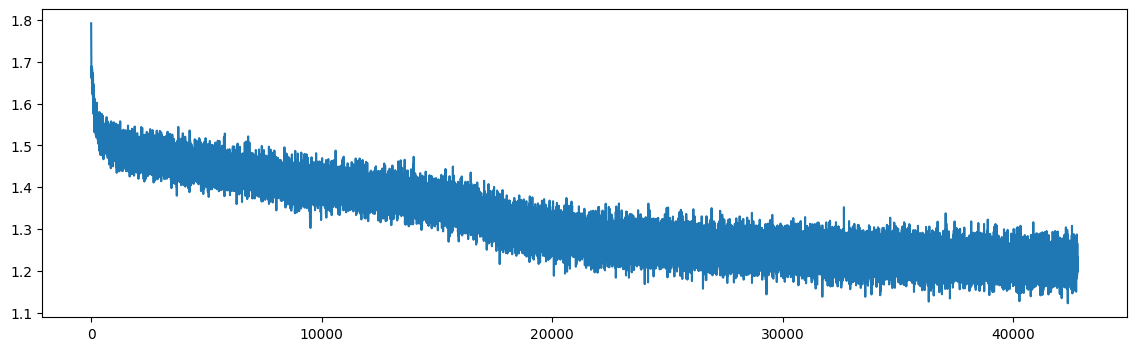

In [28]:
plt.figure(figsize=(14,4))
plt.plot(losses)
plt.show()

In [29]:
PATH = "patchtst_for_classification.pt"
torch.save(model.state_dict(), PATH)
print(f"Model state_dict saved to {PATH}")

Model state_dict saved to patchtst_for_classification.pt


In [13]:

config = PatchTSTConfig(context_length=100, 
                               patch_length=10, 
                               num_input_channels=1, 
                               num_hidden_layers=1,
                               ffn_dim = 256,
                               channel_attention=True,
                               num_targets=dataset.num_clusters)
PATH = "patchtst_for_classification.pt"
model = PatchTSTForClassification(config).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

losses = []
loader = DataLoader(dataset, batch_size=64*16, shuffle=True, num_workers=8)
epochs = 100
accuracy = AverageMeter()
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(past_values=x_batch, target_values=y_batch)
        y_preds = torch.argmax(outputs["prediction_logits"], dim=1)
        accuracy.update(torch.mean((y_preds == y_batch).float()).item(), x.shape[0])
print(f"Accuracy: {accuracy.avg}")

100%|██████████| 428/428 [00:23<00:00, 18.56it/s]

Accuracy: 0.7557997419455341
